In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best/tensorflow2/default/1/best.pt
/kaggle/input/v8trained/tensorflow2/default/1/v8.pt
/kaggle/input/yolov55/tensorflow2/default/1/best.pt
/kaggle/input/test122/neww.jpg


In [6]:
!pip install ultralytics


  Using cached ultralytics-8.3.139-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached ultralytics-8.3.139-py3-none-any.whl (1.0 MB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
Using cached ultralytics_thop-2.0.14-py3-none-any.whl (26 kB)
  


0: 576x1024 300 craters, 210.1ms
Speed: 4.2ms preprocess, 210.1ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)
Number of craters detected: 300


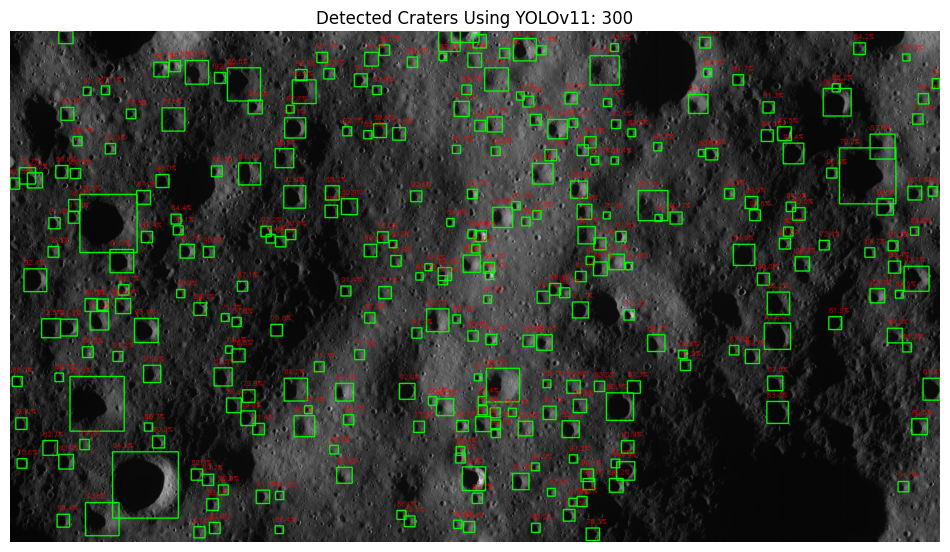

Annotated image saved to: craters_detected.jpg


In [42]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os

# === Load YOLO model ===
model_path = '/kaggle/input/best/tensorflow2/default/1/best.pt'
assert os.path.exists(model_path), f"Model path does not exist: {model_path}"
model = YOLO(model_path)

# === Load the image ===
image_path = '/kaggle/input/test122/neww.jpg'
assert os.path.exists(image_path), f"Image path does not exist: {image_path}"
img = cv2.imread(image_path)
assert img is not None, "Failed to load image."

# === Run inference with stricter filtering ===
results = model.predict(
    source=img,
    conf=0.02,         # Higher confidence threshold
    iou=0.3,          # Higher IoU threshold (merges more boxes)
    augment=True,    # Disable augmentation to reduce extra detections
    agnostic_nms=True,
    imgsz=1024
)

# === Draw bounding boxes and confidence scores ===
annotated_img = img.copy()
boxes = results[0].boxes

for box, score in zip(boxes.xyxy, boxes.conf):
    x1, y1, x2, y2 = map(int, box.tolist())
    confidence_pct = f'{score * 100:.1f}%'

    cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(annotated_img, confidence_pct, (x1, max(0, y1 - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# === Display results ===
num_craters = len(boxes)
print(f"Number of craters detected: {num_craters}")

img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f'Detected Craters Using YOLOv11: {num_craters}')
plt.show()

# === Save output ===
output_path = 'craters_detected.jpg'
cv2.imwrite(output_path, annotated_img)
print(f"Annotated image saved to: {output_path}")


In [5]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Load YOLOv5 model from PyTorch .pt file
model = torch.hub.load('ultralytics/yolov5:v6.2', 'custom', path='/kaggle/input/yolov55/tensorflow2/default/1/best.pt')
model.eval()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# List of sample images
sample_images = [
    '/kaggle/input/test122/neww.jpg'
]

# Process each image
for image_path in sample_images:
    frame = cv2.imread(image_path)

    if frame is None:
        print(f"Error: Could not read image at path: {image_path}")
        continue

    # Convert BGR to RGB for inference
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Run inference
    results = model(img_rgb)

    # Get detections
    boxes = results.xyxy[0].cpu().numpy()  # Format: (x1, y1, x2, y2, conf, cls)

    # Print number of detected craters
    num_craters = len(boxes)
    print(f"Number of craters detected: {num_craters}")

    # Draw bounding boxes
    pred_img = frame.copy()
    for box in boxes:
        x1, y1, x2, y2, conf, cls = box
        cv2.rectangle(pred_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(pred_img, f'{conf:.2f}', (int(x1), int(y1) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Display images using matplotlib
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
    ax2.set_title(f'Detected Craters: {num_craters}')
    ax2.axis('off')

    # Ensure display in Kaggle notebook
    display(plt.gcf())


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_v6.2
requirements: torch>=1.7.0 not found and is required by YOLOv5, attempting auto-update...

requirements: torchvision>=0.8.1 not found and is required by YOLOv5, attempting auto-update...

requirements: protobuf<=3.20.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 3 packages updated per /root/.cache/torch/hub/ultralytics_yolov5_v6.2/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2025-5-15 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)



Exception: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL models.yolo.DetectionModel was not an allowed global by default. Please use `torch.serialization.add_safe_globals([DetectionModel])` or the `torch.serialization.safe_globals([DetectionModel])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.. Cache may be out of date, try `force_reload=True` or see https://github.com/ultralytics/yolov5/issues/36 for help.

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi


0: 608x640 113 craters, 82.6ms
Speed: 1.7ms preprocess, 82.6ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 120 craters, 61.4ms
Speed: 1.5ms preprocess, 61.4ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 116 craters, 61.5ms
Speed: 1.4ms preprocess, 61.5ms inference, 2.4ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 118 craters, 59.9ms
Speed: 1.7ms preprocess, 59.9ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)

0: 640x608 120 craters, 65.2ms
Speed: 2.4ms preprocess, 65.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 640x480 110 craters, 48.8ms
Speed: 2.6ms preprocess, 48.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 87 craters, 39.3ms
Speed: 2.4ms preprocess, 39.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 41 craters, 24.6ms
Speed: 1.1ms preprocess, 24.6ms inference, 1.3ms postprocess per im

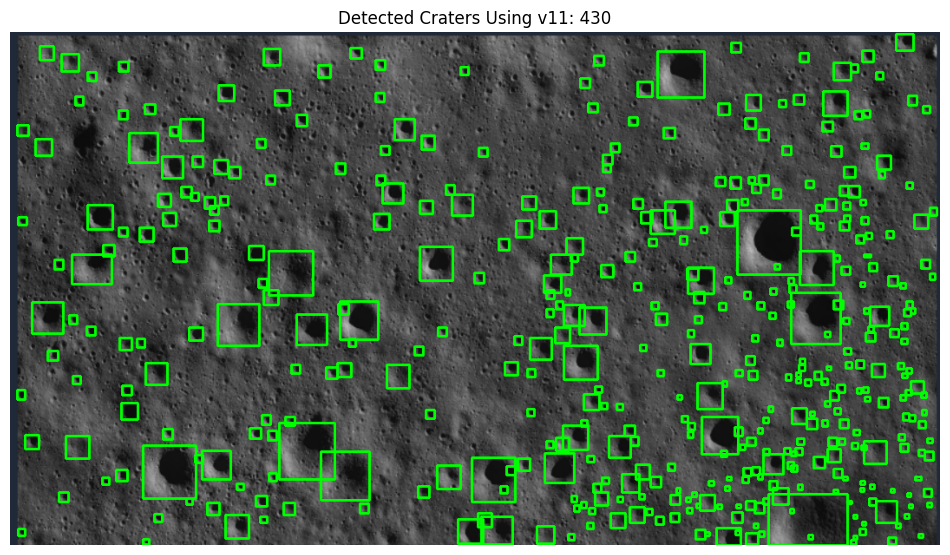

True

In [13]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import torch
from torchvision.ops import nms
import numpy as np

# Load model (trained at 640x640)
model = YOLO('/kaggle/input/best/tensorflow2/default/1/best.pt')

# Load image
image_path = '/kaggle/input/test-1/Screenshot 2025-04-26 151119.png'
original_img = cv2.imread(image_path)
original_h, original_w = original_img.shape[:2]

# Parameters
tile_size = 640
stride = 128  # overlap
conf_thres = 0.12
iou_nms = 0.3

# Containers for predictions
all_boxes, all_scores, all_classes = [], [], []

# Slide over the image
for y in range(0, original_h, stride):
    for x in range(0, original_w, stride):
        # Crop tile
        tile = original_img[y:y + tile_size, x:x + tile_size]
        tile_h, tile_w = tile.shape[:2]
        if tile_h < 64 or tile_w < 64:
            continue  # skip very small edges

        # Predict
        results = model.predict(tile, imgsz=640, conf=conf_thres, iou=0.4, augment=False)
        boxes = results[0].boxes

        if boxes is not None and boxes.xyxy.numel() > 0:
            for box, score, cls in zip(boxes.xyxy, boxes.conf, boxes.cls):
                x1, y1, x2, y2 = box
                # Shift box back to original image coordinates
                all_boxes.append([x1 + x, y1 + y, x2 + x, y2 + y])
                all_scores.append(score)
                all_classes.append(cls)

# Convert to tensors
if len(all_boxes) > 0:
    all_boxes = torch.tensor(all_boxes)
    all_scores = torch.tensor(all_scores)
    all_classes = torch.tensor(all_classes)

    # Apply NMS
    indices = nms(all_boxes, all_scores, iou_nms)

    final_boxes = all_boxes[indices]
    final_scores = all_scores[indices]
    final_classes = all_classes[indices]

    # Draw boxes (no confidence score or class name)
    for box in final_boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    print(f"Number of craters detected after sliding window NMS: {len(indices)}")
else:
    print("No detections.")

# Display
img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f'Detected Craters Using v11: {len(indices)}' if len(all_boxes) > 0 else "No craters detected")
plt.show()

# Save result
cv2.imwrite('craters_detected_sliding_window.jpg', original_img)



0: 384x640 152 craters, 62.2ms
Speed: 2.0ms preprocess, 62.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x608 221 craters, 69.8ms
Speed: 2.4ms preprocess, 69.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)

0: 64x640 66 craters, 16.8ms
Speed: 0.7ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 640)

0: 96x640 50 craters, 17.0ms
Speed: 0.8ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 96, 640)
Number of craters detected after sliding window NMS: 338


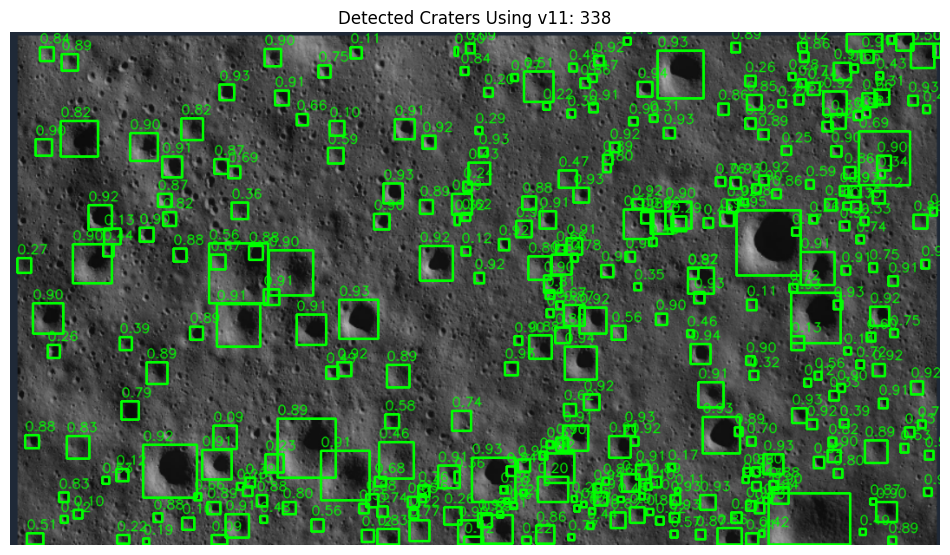

True

In [12]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import torch
from torchvision.ops import nms
import numpy as np

# Load model (trained at 640x640)
model = YOLO('/kaggle/input/best/tensorflow2/default/1/best.pt')

# Load image
image_path = '/kaggle/input/test-1/Screenshot 2025-04-26 151119.png'
original_img = cv2.imread(image_path)
original_h, original_w = original_img.shape[:2]

# Parameters
tile_size = 1024
stride = 512  # overlap
conf_thres = 0.09
iou_nms = 0.3

# Containers for predictions
all_boxes, all_scores, all_classes = [], [], []

# Slide over the image
for y in range(0, original_h, stride):
    for x in range(0, original_w, stride):
        # Crop tile
        tile = original_img[y:y + tile_size, x:x + tile_size]
        tile_h, tile_w = tile.shape[:2]
        if tile_h < 64 or tile_w < 64:
            continue  # skip very small edges

        # Predict
        results = model.predict(tile, imgsz=640, conf=conf_thres, iou=0.4, augment=False)
        boxes = results[0].boxes

        if boxes is not None and boxes.xyxy.numel() > 0:
            for box, score, cls in zip(boxes.xyxy, boxes.conf, boxes.cls):
                x1, y1, x2, y2 = box
                # Shift box back to original image coordinates
                all_boxes.append([x1 + x, y1 + y, x2 + x, y2 + y])
                all_scores.append(score)
                all_classes.append(cls)

# Convert to tensors
if len(all_boxes) > 0:
    all_boxes = torch.tensor(all_boxes)
    all_scores = torch.tensor(all_scores)
    all_classes = torch.tensor(all_classes)

    # Apply NMS
    indices = nms(all_boxes, all_scores, iou_nms)

    final_boxes = all_boxes[indices]
    final_scores = all_scores[indices]
    final_classes = all_classes[indices]

    # Draw boxes and confidence scores
    for box, score in zip(final_boxes, final_scores):
        x1, y1, x2, y2 = map(int, box)
        # Draw rectangle
        cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Prepare confidence text, formatted to two decimals
        conf_text = f"{score:.2f}"
        # Put text just above the top-left corner of the box
        cv2.putText(
            original_img,
            conf_text,
            (x1, y1 - 5),                  # position (slightly above box)
            cv2.FONT_HERSHEY_SIMPLEX,      # font
            0.5,                           # font scale
            (0, 255, 0),                   # text color (green)
            1,                             # line thickness
            cv2.LINE_AA                    # line type for smoother text
        )

    print(f"Number of craters detected after sliding window NMS: {len(indices)}")
else:
    print("No detections.")

# Display
img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f'Detected Craters Using v11: {len(indices)}' if len(all_boxes) > 0 else "No craters detected")
plt.show()

# Save result
cv2.imwrite('craters_detected_sliding_window.jpg', original_img)
